Implement a program on Adversarial training, tangent distance, tangent prop and tangent classifier.

Epoch 1/5
79/79 [==============================] - 1s 3ms/step - loss: 0.8441 - accuracy: 0.7796
Epoch 2/5
79/79 [==============================] - 0s 3ms/step - loss: 0.3354 - accuracy: 0.9106
Epoch 3/5
79/79 [==============================] - 0s 3ms/step - loss: 0.2596 - accuracy: 0.9312
Epoch 4/5
79/79 [==============================] - 0s 3ms/step - loss: 0.2109 - accuracy: 0.9460
Epoch 5/5
79/79 [==============================] - 0s 3ms/step - loss: 0.1765 - accuracy: 0.9550
Epoch 1/5 completed
Epoch 2/5 completed
Epoch 3/5 completed
Epoch 4/5 completed
Epoch 5/5 completed


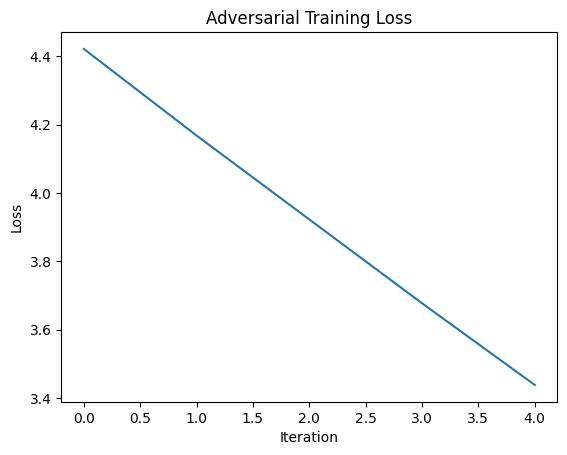

Epoch 1/5 completed
Epoch 2/5 completed
Epoch 3/5 completed
Epoch 4/5 completed
Epoch 5/5 completed


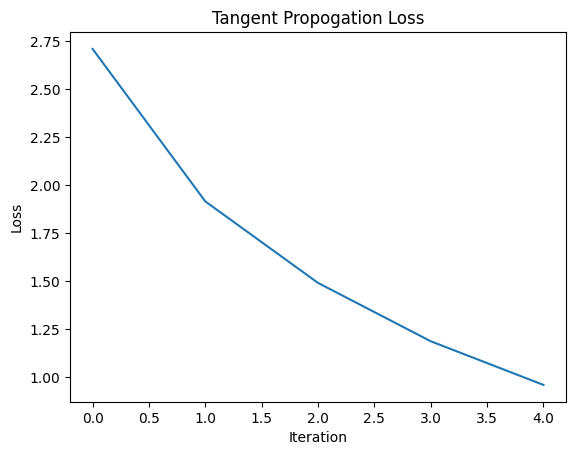

Tangent Classifier Accuracy: 0.9


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train, y_train = x_train[:5000], y_train[:5000]
x_test, y_test = x_test[:1000], y_test[:1000]

x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int64)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int64)

model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

def plot_loss(losses, title):
    plt.plot(losses)
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()

def create_adversarial_pattern(model, input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = tf.keras.losses.sparse_categorical_crossentropy(input_label, prediction)
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad, loss

def adversarial_training(model, x_train, y_train, epochs=5, epsilon=0.1):
    batch_size = 64
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(0, len(x_train), batch_size):
            x_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            perturbations, loss = create_adversarial_pattern(model, x_batch, y_batch)
            epoch_loss += np.mean(loss)
            x_adv = x_batch + epsilon * perturbations
            x_adv = tf.clip_by_value(x_adv, 0, 1)
            model.train_on_batch(x_adv, y_batch)
        print(f"Epoch {epoch+1}/{epochs} completed")
        losses.append(epoch_loss/epochs)
    plot_loss(losses, "Adversarial Training Loss")

model.fit(x_train, y_train, epochs=5, batch_size=64)
adversarial_training(model, x_train, y_train, epochs=5)
tangent_vectors = tf.random.normal((28, 28))

def tangent_propagation_loss(model, x, y, lambda_tangent=0.1):
    with tf.GradientTape() as tape:
        tape.watch(x)
        predictions = model(x)
        classification_loss = tf.keras.losses.sparse_categorical_crossentropy(y, predictions)

    gradients = tape.gradient(predictions, x)
    tangent_loss = tf.reduce_sum(tf.square(tf.tensordot(gradients, tangent_vectors, axes=1)))

    return classification_loss + lambda_tangent * tangent_loss


def train_with_tangent_propagation(model, x_train, y_train, epochs=5, lambda_tangent=0.1):
    optimizer = tf.keras.optimizers.Adam()
    batch_size = 64
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(0, len(x_train), batch_size):
            x_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            with tf.GradientTape() as tape:
                loss = tangent_propagation_loss(model, x_batch, y_batch, lambda_tangent)
            epoch_loss += np.mean(loss)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        print(f"Epoch {epoch+1}/{epochs} completed")
        losses.append(epoch_loss/epochs)
    plot_loss(losses, "Tangent Propogation Loss")

train_with_tangent_propagation(model, x_train, y_train, epochs=5)

def tangent_classifier(model, x_train, y_train, x_test, tangent_vectors):
    x_train_flat = tf.reshape(x_train, (x_train.shape[0], -1))
    x_test_flat = tf.reshape(x_test, (x_test.shape[0], -1))

    distances = tf.norm(x_test_flat[:, tf.newaxis, :] - x_train_flat[tf.newaxis, :, :], axis=2)
    nearest_indices = tf.argmin(distances, axis=1)
    predictions = tf.gather(y_train, nearest_indices)
    return predictions.numpy()

y_pred = tangent_classifier(model, x_train.numpy(), y_train.numpy(), x_test[:100].numpy(), tangent_vectors.numpy())
print("Tangent Classifier Accuracy:", np.mean(y_pred == y_test[:100].numpy()))
